In [151]:
# General Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import defaultdict

# Encoding libraries
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder, BinaryEncoder
from sklearn.preprocessing import LabelEncoder

# Scaling Libraries
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
# Normalizing Libraries
from sklearn.preprocessing import Normalizer
from scipy.stats import boxcox, mstats

# Imputation Libraries
from sklearn.impute import KNNImputer

# Feature Work Libraries - Selection, Engineering, Decomposition
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.feature_selection import RFE, SelectKBest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, FastICA, KernelPCA


# Testing libraries
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor, multipletests, outlier_test
from scipy.stats import chi2_contingency

from sklearn.pipeline import  Pipeline, make_pipeline, FunctionTransformer

In [152]:
# import data and drop secondary predictors and datetime columns
data = pd.read_csv('hotel_bookings.csv')
dependent_var = data.is_canceled.copy()
data = data.drop([_ for _ in data.columns if _.__contains__('date')], axis = 1).\
    drop(['reservation_status', 'is_canceled'], axis = 1)

In [153]:
data[['agent', 'company']] = data[['agent', 'company']].fillna(0)
cat_cols = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type',
            'deposit_type', 'agent', 'company', 'customer_type']
data[cat_cols] = data[cat_cols].astype('category')

In [154]:
def outlier_removal(data_frame):
    df = data_frame.copy()
    numerical_cols = [_ for _ in data.columns if data[_].dtype in ['float64', 'int64']]
    for col in numerical_cols:
        x = mstats.winsorize(df[f'{col}'], limits=[0.05,0.05])
        df[f'{col}'] = pd.DataFrame(x)
    return df

In [155]:
data_treated = outlier_removal(data)

# Ordinal Categorical Data

In [156]:
# Dealing with low cardinality ordinal data
ordinal_cols = ['meal', 'reserved_room_type', 'assigned_room_type', 'deposit_type']
ordinal_data = data.copy()
ordinal_data = ordinal_data[ordinal_cols]
# from the data dictionary, we know that sc and undefined mean no meal package for the customer, with undefined being used to avoid excessive labels
ordinal_data.meal = ordinal_data.meal.replace('Undefined', 'SC')
# let's re-level the data now
ordinal_data.meal = ordinal_data.meal.cat.reorder_categories(['SC', 'BB', 'HB', 'FB'], ordered = True)
ordinal_data.meal.unique()
# let's move onto room types
# Here we can make an assumption that the less common rooms would be the more premium ones
# to check this, we can count values after grouping
# our order is hence
grouped = ordinal_data.groupby('reserved_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
# re-level the data for reserved room types
ordinal_data.reserved_room_type = ordinal_data.reserved_room_type.cat.reorder_categories(room_order, ordered = True)
del grouped
del room_order
# repeat for assigned_room_type
grouped = ordinal_data.groupby('assigned_room_type').count().sort_values(by = 'meal', ascending=False).index
room_order = [_ for _ in grouped]
ordinal_data.assigned_room_type = ordinal_data.assigned_room_type.cat.reorder_categories(room_order, ordered = True)
del grouped
del room_order
# we can reorder deposit_type as is
ordinal_data.deposit_type = ordinal_data.deposit_type.cat.reorder_categories(['No Deposit', 'Refundable', 'Non Refund'], ordered = True)
ordinal_data.head()

,meal,reserved_room_type,assigned_room_type,deposit_type
0,BB,C,C,No Deposit
1,BB,C,C,No Deposit
2,BB,A,C,No Deposit
3,BB,A,A,No Deposit
4,BB,A,A,No Deposit


In [157]:
# apply the label encoder to these columns
le = LabelEncoder()
for col in ordinal_cols:
    ordinal_data[col] = pd.DataFrame(le.fit_transform(ordinal_data[col]), columns=[col])
ordinal_data.head()

,meal,reserved_room_type,assigned_room_type,deposit_type
0,0,2,2,0
1,0,2,2,0
2,0,0,2,0
3,0,0,0,0
4,0,0,0,0


In [158]:
# replace the ordinal columns in original dataframe with ordinal encoded
for col in ordinal_data.columns:
    data[col] = ordinal_data[col]

data[ordinal_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   meal                119390 non-null  int32
 1   reserved_room_type  119390 non-null  int32
 2   assigned_room_type  119390 non-null  int32
 3   deposit_type        119390 non-null  int32
dtypes: int32(4)
memory usage: 1.8 MB


# Now, we are left with the nominal categorical variables
## For this, we employ 3 different strategies
### For variables with less than 5 categories, we use frequency encoding
### For less than 20 we use Leave one out encoding which is a form of target encoding which leaves out the current row of data
### Catboost encoding is used for the rest

In [174]:
def cat_encoder(data_frame: pd.DataFrame, target: pd.DataFrame):
    df = data_frame.copy()
    target = target.copy()
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.33, random_state=2407)
    categorical_cols = df.select_dtypes(include=['category']).columns
    loo = LeaveOneOutEncoder()
    loo_counter = 0
    cb = CatBoostEncoder()
    cb_counter  = 0
    if len(categorical_cols) > 0:
        for col in categorical_cols:

            if len(df[col].unique()) < 10:
                train_freq_encoding = X_train[col].value_counts(normalize=True)
                test_freq_encoding = X_test[col].value_counts(normalize=True)

                X_train[col] = X_train[col].map(train_freq_encoding)
                X_test[col] = X_test[col].map(test_freq_encoding)

            elif len(df[col].unique()) < 50:
                if loo_counter == 0 :
                    loo.fit(X_train, y_train)
                    loo_counter += 1
                X_train[col] = loo.transform(X_train[col])
                X_test[col] = loo.transform(X_test[col])

            else:
                # Catboost encoding for high cardinality categories
                cb.fit(X_train[col], y_train)
                X_train[col] = cb.transform(X_train[col])
                X_test[col] = cb.transform(X_test[col])

    return X_train, X_test, y_train, y_test

In [175]:
X_train_encoded, X_test_encoded, y_train, y_test = cat_encoder(data, dependent_var)

In [176]:
def data_impute(train_data_frame, test_data_frame):
    train_df = train_data_frame.copy()
    test_df = test_data_frame.copy()
    imputer = KNNImputer(copy = False)
    train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=imputer.feature_names_in_)
    test_df = pd.DataFrame(imputer.transform(test_df), columns=imputer.feature_names_in_)
    return train_df, test_df

In [177]:
X_train_imputed, X_test_imputed = data_impute(X_train_encoded, X_test_encoded)

In [184]:
X_train_imputed.to_parquet('X_train_imputed.gzip.parquet', compression='gzip', index=False)
X_test_imputed.to_parquet('X_test_imputed.gzip.parquet', compression='gzip', index=False)

<Axes: >

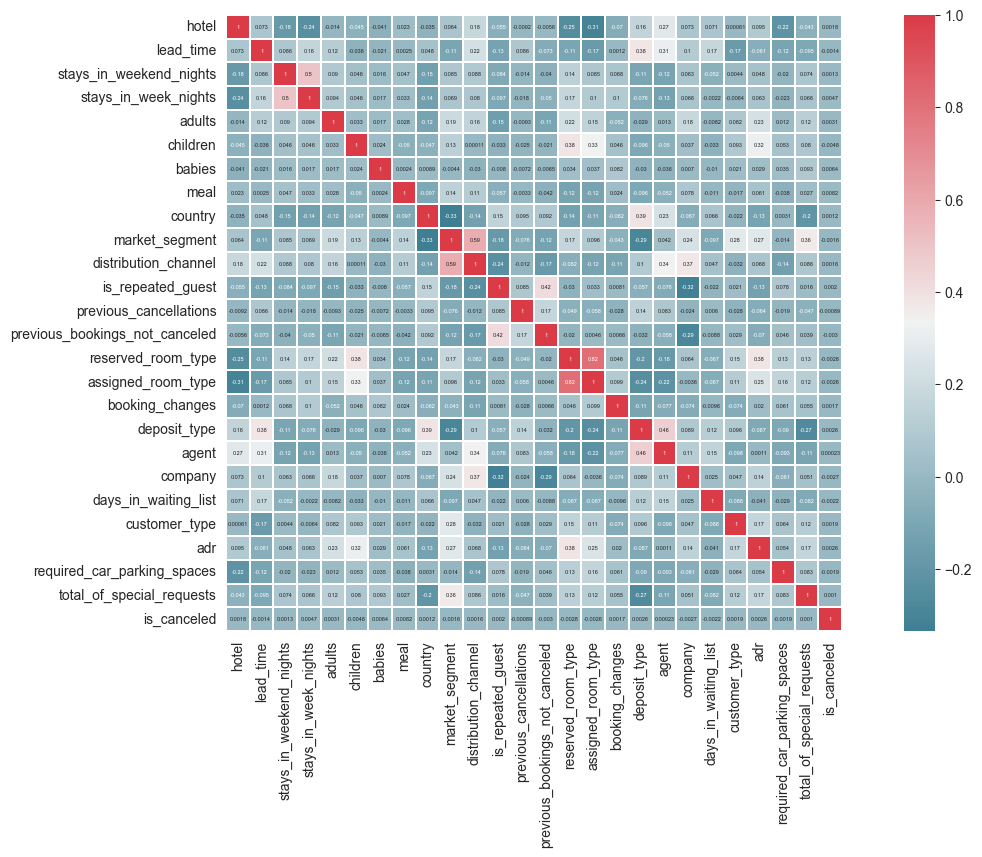

In [178]:
corr = pd.concat([X_train_imputed.copy(), dependent_var], axis=1).corr(numeric_only=True)
f, ax = plt.subplots(figsize=(16,8))

sns.heatmap(corr, mask=np.zeros_like(corr, dtype= bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True), linewidths=0.1,
            annot=True,
            vmin=corr.values.min(), vmax=1, annot_kws={"fontsize":4},
            xticklabels=1, yticklabels=1,
            square=True, ax=ax)

In [179]:
# Apply scaling
def multi_scaler(data_frame: pd.DataFrame, test_data_frame: pd.DataFrame):
    df = data_frame.copy()
    test_df = test_data_frame.copy()
    col_list = df.columns

    robust_scaler = RobustScaler()
    robust_data = pd.DataFrame(robust_scaler.fit_transform(df), columns=col_list)
    test_robust_data = pd.DataFrame(robust_scaler.transform(test_df), columns=col_list)

    min_max_scaler = MinMaxScaler()
    min_max_data = pd.DataFrame(min_max_scaler.fit_transform(df), columns=col_list)
    test_min_max_data = pd.DataFrame(min_max_scaler.transform(test_df), columns=col_list)

    max_abs_scaler = MaxAbsScaler()
    max_abs_data = pd.DataFrame(max_abs_scaler.fit_transform(df), columns=col_list)
    test_max_abs_data = pd.DataFrame(max_abs_scaler.transform(test_df), columns=col_list)

    standard_scaler = StandardScaler()
    standard_data = pd.DataFrame(standard_scaler.fit_transform(df), columns=col_list)
    test_standard_data = pd.DataFrame(standard_scaler.transform(test_df), columns=col_list)

    return robust_data, min_max_data, max_abs_data, standard_data, test_robust_data,\
        test_min_max_data, test_max_abs_data, test_standard_data

In [180]:
X_train_robust_data, X_train_min_max_data, X_train_max_abs_data, X_train_standard_data, \
    X_test_robust_data, X_test_min_max_data, X_test_max_abs_data, X_test_standard_data = multi_scaler(X_train_imputed, X_test_imputed)

In [185]:
# Apply scaling
def multi_scaler_arcsinh(data_frame: pd.DataFrame, test_data_frame: pd.DataFrame):
    df = data_frame.copy()
    test_df = test_data_frame.copy()
    col_list = df.columns

    for col in df.columns:
        df[col] = np.arcsinh(df[col])

    robust_scaler = RobustScaler()
    robust_data = pd.DataFrame(robust_scaler.fit_transform(df), columns=col_list)
    test_robust_data = pd.DataFrame(robust_scaler.transform(test_df), columns=col_list)

    min_max_scaler = MinMaxScaler()
    min_max_data = pd.DataFrame(min_max_scaler.fit_transform(df), columns=col_list)
    test_min_max_data = pd.DataFrame(min_max_scaler.transform(test_df), columns=col_list)

    max_abs_scaler = MaxAbsScaler()
    max_abs_data = pd.DataFrame(max_abs_scaler.fit_transform(df), columns=col_list)
    test_max_abs_data = pd.DataFrame(max_abs_scaler.transform(test_df), columns=col_list)

    standard_scaler = StandardScaler()
    standard_data = pd.DataFrame(standard_scaler.fit_transform(df), columns=col_list)
    test_standard_data = pd.DataFrame(standard_scaler.transform(test_df), columns=col_list)

    return robust_data, min_max_data, max_abs_data, standard_data, test_robust_data, \
        test_min_max_data, test_max_abs_data, test_standard_data

In [186]:
X_train_robust_data_arcsinh, X_train_min_max_data_arcsinh, X_train_max_abs_data_arcsinh, X_train_standard_data_arcsinh, \
    X_test_robust_data_arcsinh, X_test_min_max_data_arcsinh, X_test_max_abs_data_arcsinh, X_test_standard_data_arcsinh = multi_scaler_arcsinh(X_train_imputed, X_test_imputed)

In [187]:
X_train_robust_data.to_parquet('X_train_robust_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_test_robust_data.to_parquet('X_test_robust_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_train_min_max_data.to_parquet('X_train_min_max_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_test_min_max_data.to_parquet('X_test_min_max_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_train_max_abs_data.to_parquet('X_train_max_abs_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_test_max_abs_data.to_parquet('X_test_max_abs_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_train_standard_data.to_parquet('X_train_standard_data_arcsinh.gzip.parquet', compression='gzip', index=False)
X_test_standard_data.to_parquet('X_test_standard_data_arcsinh.gzip.parquet', compression='gzip', index=False)

In [181]:
X_train_robust_data.to_parquet('X_train_robust_data.gzip.parquet', compression='gzip', index=False)
X_test_robust_data.to_parquet('X_test_robust_data.gzip.parquet', compression='gzip', index=False)
X_train_min_max_data.to_parquet('X_train_min_max_data.gzip.parquet', compression='gzip', index=False)
X_test_min_max_data.to_parquet('X_test_min_max_data.gzip.parquet', compression='gzip', index=False)
X_train_max_abs_data.to_parquet('X_train_max_abs_data.gzip.parquet', compression='gzip', index=False)
X_test_max_abs_data.to_parquet('X_test_max_abs_data.gzip.parquet', compression='gzip', index=False)
X_train_standard_data.to_parquet('X_train_standard_data.gzip.parquet', compression='gzip', index=False)
X_test_standard_data.to_parquet('X_test_standard_data.gzip.parquet', compression='gzip', index=False)

In [182]:
pd.DataFrame(y_train).to_parquet('y_train_data.gzip.parquet', compression='gzip', index=False)
pd.DataFrame(y_test).to_parquet('y_test_data.gzip.parquet', compression='gzip', index=False)

# Defining a function to plot the variance of PCA across all features to select an optimal number of points to reduce features to

In [83]:
def plot_pca_variance(data, n_components=None):
    """
    Plots the explained variance ratio for a range of component numbers for PCA on the input data.
    Parameters:
        data (array-like): The input data to perform PCA on.
        n_components (int or None): The maximum number of components to plot. If None (default), plot all components.
    """
    # Initialize a PCA object and fit it to the data
    pca = PCA()
    pca.fit(data)

    # Compute the explained variance ratio for each component
    variance_ratios = pca.explained_variance_ratio_

    # Compute the cumulative explained variance ratio for each component
    cumulative_variance_ratios = np.cumsum(variance_ratios)

    # Determine the number of components to plot
    if n_components is None:
        n_components = len(variance_ratios)

    # Plot the explained variance ratio for each component
    plt.plot(range(1, n_components + 1), variance_ratios[:n_components], '-o', label='Explained Variance Ratio')
    plt.plot(range(1, n_components + 1), cumulative_variance_ratios[:n_components], '-o', label='Cumulative Explained Variance Ratio')

    # Set the plot labels and title
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')

    # Show the legend and plot the figure
    plt.legend()
    plt.show()

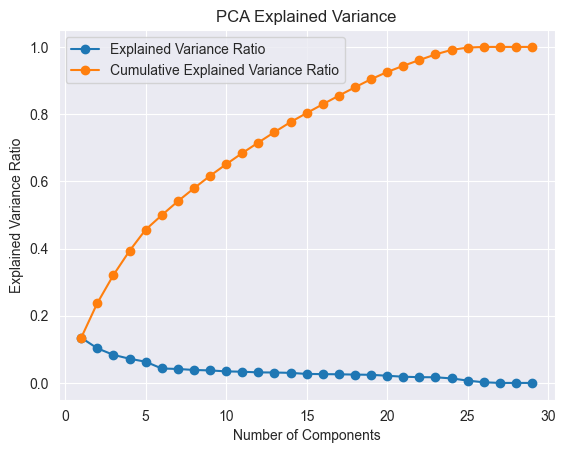

In [96]:
plot_pca_variance(X_train_standard_data, n_components=None)

In [97]:
n_comp = 25
pca = PCA(n_components=n_comp)
feature_names = []
for i in range(n_comp):
    feature_names.append(f"PCA{i}")

X_train_standard_data_pca = pd.DataFrame(pca.fit_transform(X_train_standard_data), columns=feature_names)
X_test_standard_data_pca = pd.DataFrame(pca.transform(X_test_standard_data), columns = feature_names)

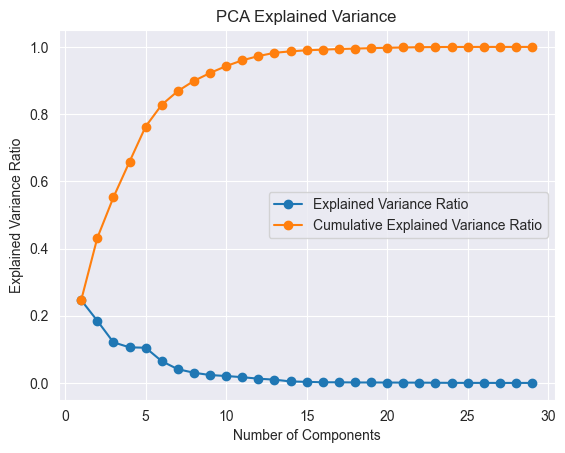

In [98]:
plot_pca_variance(X_train_min_max_data, n_components=None)

In [99]:
n_comp = 15
pca = PCA(n_components=n_comp)
feature_names = []
for i in range(n_comp):
    feature_names.append(f"PCA{i}")
X_train_min_max_data_pca = pd.DataFrame(pca.fit_transform(X_train_min_max_data), columns=feature_names)
X_test_min_max_data_pca = pd.DataFrame(pca.transform(X_test_min_max_data), columns = feature_names)

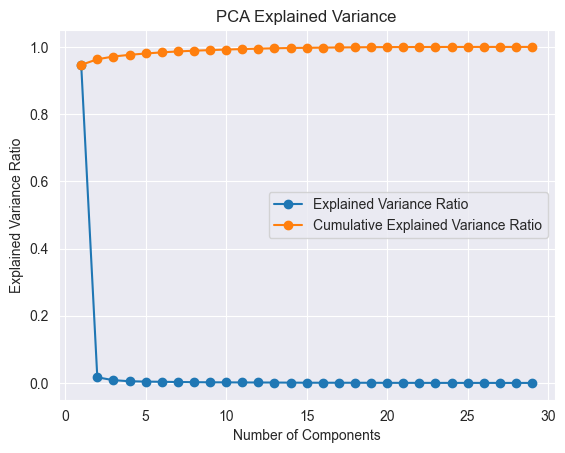

In [100]:
plot_pca_variance(X_train_robust_data, n_components=None)

# No linear relationship between variables when they have been scaled using a robust scaler

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
lr = LogisticRegression(max_iter=1000, l1_ratio=0.1, solver='saga', n_jobs=-1, penalty='elasticnet')
lr.fit(X_train_robust_data, y_train)
print(classification_report(y_test, lr.predict(X_test_robust_data)))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80     24811
           1       0.67      0.59      0.63     14588

    accuracy                           0.74     39399
   macro avg       0.73      0.71      0.72     39399
weighted avg       0.74      0.74      0.74     39399



C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


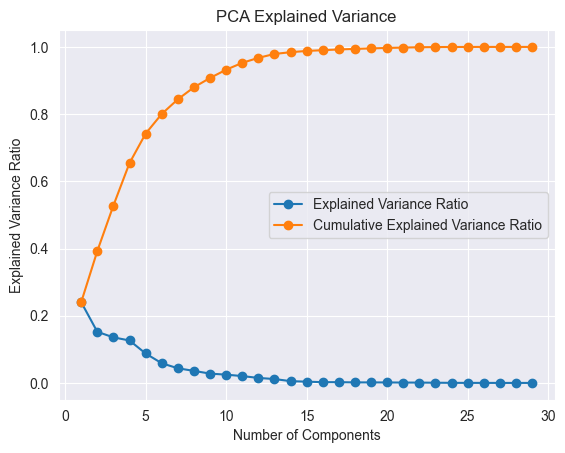

In [102]:
plot_pca_variance(X_train_max_abs_data)

In [103]:
n_comp = 15
pca = PCA(n_components=n_comp)
feature_names = []
for i in range(n_comp):
    feature_names.append(f"PCA{i}")
X_train_max_abs_data_pca = pd.DataFrame(pca.fit_transform(X_train_max_abs_data), columns=feature_names)
X_test_max_abs_data_pca = pd.DataFrame(pca.transform(X_test_max_abs_data), columns = feature_names)

In [105]:
X_train_min_max_data_pca.to_parquet('X_train_min_max_data_pca.gzip.parquet', compression='gzip', index=False)
X_test_min_max_data_pca.to_parquet('X_test_min_max_data_pca.gzip.parquet', compression='gzip', index=False)
X_train_max_abs_data_pca.to_parquet('X_train_max_abs_data_pca.gzip.parquet', compression='gzip', index=False)
X_test_max_abs_data_pca.to_parquet('X_test_max_abs_data_pca.gzip.parquet', compression='gzip', index=False)
X_train_standard_data_pca.to_parquet('X_train_standard_data_pca.gzip.parquet', compression='gzip', index=False)
X_test_standard_data_pca.to_parquet('X_test_standard_data_pca.gzip.parquet', compression='gzip', index=False)

In [126]:
lr2 = LogisticRegression(max_iter=1000, l1_ratio=0.1, solver='saga', n_jobs=-1, penalty='elasticnet')
lr2.fit(X_train_max_abs_data_pca, y_train)
print(classification_report(y_test, lr2.predict(X_test_max_abs_data_pca)))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     24811
           1       0.79      0.62      0.69     14588

    accuracy                           0.80     39399
   macro avg       0.79      0.76      0.77     39399
weighted avg       0.80      0.80      0.79     39399



In [128]:
lr2 = LogisticRegression(max_iter=1000, l1_ratio=0.1, solver='saga', n_jobs=-1, penalty='elasticnet')
lr2.fit(X_train_standard_data_pca, y_train)

C:\Users\fight\Documents\Anaconda3\envs\workspace2\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.1, max_iter=1000, n_jobs=-1, penalty='elasticnet',
                   solver='saga')

In [129]:
print(classification_report(y_test, lr2.predict(X_test_standard_data_pca)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     24811
           1       0.79      0.67      0.73     14588

    accuracy                           0.81     39399
   macro avg       0.81      0.78      0.79     39399
weighted avg       0.81      0.81      0.81     39399



In [ ]:
"""robust_data.to_parquet('robust_data.parquet.gzip', compression='gzip', index=False)
min_max_data.to_parquet('min_max_data.parquet.gzip', compression='gzip', index=False)
max_abs_data.to_parquet('max_abs_data.parquet.gzip', compression='gzip', index=False)
standard_data.to_parquet('standard_data.parquet.gzip', compression='gzip', index=False)"""

In [46]:
from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k, n_init='auto').fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse

<Axes: >

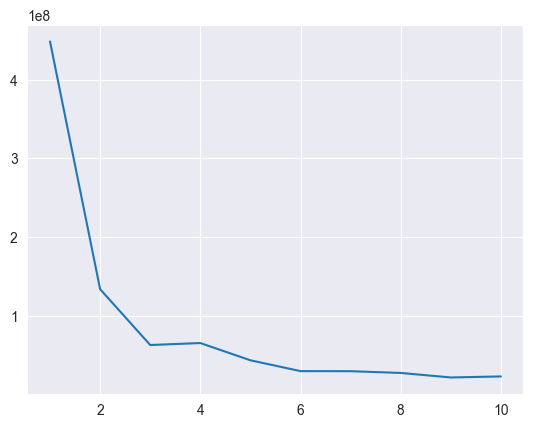

In [51]:
wss_series = pd.Series(calculate_WSS(X_test_imputed.values, 10), index=range(1,11))
wss_series.plot()